In [188]:
# import necessary libraries
import pandas as pd # pandas
import seaborn as sns # seaborn package to generate nice plots
import matplotlib.pyplot as plt # matplotlib
import numpy as np # numpy

In [189]:
# read data
in_dd=pd.read_csv('/content/tn_stock_data_2018.csv')
# convert date from string to datetime type
in_dd.date=pd.to_datetime(in_dd.date,format='%d/%m/%y')

In [190]:
# show top observations from the data
in_dd.head()

,date,C_GR_RLC,company_code,company,ref_price,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,I
0,2018-01-02,11,725001,ADWYA,5.35,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,NaN
1,2018-01-02,11,340005,AMEN BANK,24.35,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,NaN
2,2018-01-02,11,730001,ARTES,6.27,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,NaN
3,2018-01-02,11,714001,ASSAD,9.00,9.00,0.00,0.00,9.00,0.00,0.00,0,0,NaN,NaN
4,2018-01-02,11,360035,ATB,4.22,4.22,4.15,4.18,4.18,4.15,4.18,3705,7,15465.90,NaN


In [191]:
# calculate daily return for every company
in_dd['currReturn']=100*in_dd.groupby(['company'])['close'].pct_change()

In [192]:
# make a pivot to create a data matrix where columns are companies and rows are days; the values in the data matrix are for the returns
ret_data=in_dd.pivot(index='date',columns='company',values='currReturn').dropna()

In [193]:
# show the top entries from the returns matrix
ret_data.head().round(2)

company,ADWYA,AETECH,AIR LIQUDE TSIE,ALKIMIA,AMEN BANK,AMI DA 1/4 110817,AMS,ARTES,ASS MULTI ITTIHAD,ASSAD,ASSURANCES SALIM,ASTREE,ATB,ATELIER MEUBLE INT,ATL,ATTIJARI BANK,ATTIJARI LEASING,BEST LEASE,BH,BIAT,BNA,BT,BTE (ADP),CARTHAGE CEMENT,CELLCOM,CEREALIS,CIL,CIMENTS DE BIZERTE,CITY CARS,DELICE HOLDING,ELBENE INDUSTRIE,ELECTROSTAR,ENNAKL AUTOMOBILES,ESSOUKNA,EURO-CYCLES,GIF-FILTER,HANNIBAL LEASE,HEXABYTE,ICF,LAND OR,...,MPBS,NEW BODY LINE,OFFICEPLAST,ONE TECH HOLDING,PLAC. TSIE-SICAF,POULINA GP HOLDING,SAH,SANIMED,SERVICOM,SFBT,SIAME,SIMPAR,SIPHAT,SITEX,SITS,SOMOCER,SOPAT,SOTEMAIL,SOTETEL,SOTIPAPIER,SOTRAPIL,SOTUMAG,SOTUVER,SPDIT - SICAF,STAR,STB,STE TUN. DU SUCRE,STEQ,STIP,TAWASOL GP HOLDING,TELNET HOLDING,TPR,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.74,3.92,0.00,0.00,-0.04,-13.82,-2.54,2.46,-3.03,-0.11,0.00,0.0,-0.72,0.00,0.00,-1.23,-0.95,-2.63,-0.27,1.61,0.78,0.13,-2.38,-0.86,0.53,-1.98,2.73,-0.40,2.98,0.00,0.0,0.75,1.61,-1.08,3.77,-2.70,0.00,0.19,0.28,-3.33,...,-2.88,-1.01,-4.69,4.39,0.0,5.32,0.90,-0.23,-1.32,2.47,-2.95,2.78,-2.83,0.00,0.00,3.45,0.00,0.0,0.36,-0.57,0.09,1.04,-2.83,-1.22,2.04,0.81,0.00,0.00,0.0,-2.63,1.37,-2.30,0.00,-1.79,-2.33,0.41,0.0,0.41,1.91,-0.27
2018-01-04,3.74,3.77,-1.12,-3.00,-0.38,0.00,0.00,0.16,-4.50,1.11,0.00,0.0,0.48,-0.40,0.32,0.89,0.28,2.16,-2.33,-1.25,-0.09,0.00,0.06,-0.43,-0.53,2.77,2.77,0.00,-0.63,2.91,0.0,-1.50,-0.79,2.47,3.60,2.78,0.37,-2.84,2.80,2.07,...,2.31,-2.86,-5.90,-1.31,0.0,-1.48,0.89,-0.47,6.00,-0.50,-0.43,-1.11,-0.78,0.00,4.68,2.50,2.70,0.0,2.13,-0.29,1.77,0.00,-2.92,0.00,-0.02,-0.54,0.00,0.00,0.0,-2.70,2.69,-3.24,0.00,3.03,2.38,5.69,0.0,-0.45,-0.25,-2.97
2018-01-05,0.54,1.82,0.23,-4.49,0.33,0.00,0.00,0.00,-1.83,1.21,-2.99,0.0,-1.20,-2.02,0.65,1.07,0.23,0.00,-0.17,1.18,-0.77,0.00,2.50,2.17,-2.65,-0.49,0.00,0.00,4.45,-0.47,0.0,-0.38,0.80,0.80,-1.76,-1.35,-1.11,1.95,0.00,2.97,...,-2.90,0.84,-4.18,-1.40,0.0,0.00,2.60,0.00,5.66,0.00,-3.49,-1.15,2.94,0.00,5.69,4.88,0.00,0.0,0.00,-2.58,0.83,-2.56,-1.29,0.00,-2.98,-2.16,0.00,0.00,0.0,0.00,1.31,0.00,2.92,-1.29,-2.33,3.46,0.0,0.00,0.25,-0.14
2018-01-08,-1.43,3.57,0.00,-2.33,0.00,0.53,0.00,-2.56,5.87,1.63,0.00,0.0,1.21,-1.23,0.00,1.28,-0.11,0.00,-0.95,2.19,-1.21,0.00,5.86,0.85,1.09,0.00,-1.63,0.00,-1.22,0.12,0.0,-2.67,-0.79,1.33,0.64,-1.37,0.00,0.00,0.00,1.71,...,-0.33,-0.21,5.82,3.88,0.0,-1.94,5.80,-2.82,0.00,0.61,1.36,2.33,-2.85,0.00,3.85,2.33,-2.63,0.0,0.00,-0.29,0.00,2.11,2.83,1.23,-0.01,0.28,0.00,4.46,0.0,0.00,0.97,2.43,0.00,-2.15,-2.38,-1.49,0.0,2.00,2.50,2.92
2018-01-09,0.00,0.00,0.00,0.00,-0.04,5.85,0.00,0.82,-2.39,1.50,0.00,0.0,-0.48,-0.42,-0.64,0.11,-0.17,0.00,-0.67,-0.51,-2.27,0.00,5.54,-0.42,-2.69,1.97,-3.43,-3.61,0.09,-0.41,0.0,1.96,-0.40,0.79,-0.60,-0.69,0.00,-0.19,0.00,-0.13,...,-1.00,0.00,2.41,-1.08,0.0,-1.80,-1.98,0.00,-4.17,-1.46,-2.68,-0.23,2.94,-2.88,-4.07,-2.27,0.00,0.0,-2.78,-0.59,0.00,0.00,1.90,0.00,-2.05,0.00,-2.96,0.00,0.0,-2.78,-1.28,0.89,-4.48,-2.31,0.00,-2.64,0.0,-0.18,0.00,-0.95


In [194]:
ret_data.shape

(248, 84)

## part 1 : exploratory data analysis

Let's start by getting familiar the DataFrame.

In [195]:
ret_data.describe()

company,ADWYA,AETECH,AIR LIQUDE TSIE,ALKIMIA,AMEN BANK,AMI DA 1/4 110817,AMS,ARTES,ASS MULTI ITTIHAD,ASSAD,ASSURANCES SALIM,ASTREE,ATB,ATELIER MEUBLE INT,ATL,ATTIJARI BANK,ATTIJARI LEASING,BEST LEASE,BH,BIAT,BNA,BT,BTE (ADP),CARTHAGE CEMENT,CELLCOM,CEREALIS,CIL,CIMENTS DE BIZERTE,CITY CARS,DELICE HOLDING,ELBENE INDUSTRIE,ELECTROSTAR,ENNAKL AUTOMOBILES,ESSOUKNA,EURO-CYCLES,GIF-FILTER,HANNIBAL LEASE,HEXABYTE,ICF,LAND OR,...,MPBS,NEW BODY LINE,OFFICEPLAST,ONE TECH HOLDING,PLAC. TSIE-SICAF,POULINA GP HOLDING,SAH,SANIMED,SERVICOM,SFBT,SIAME,SIMPAR,SIPHAT,SITEX,SITS,SOMOCER,SOPAT,SOTEMAIL,SOTETEL,SOTIPAPIER,SOTRAPIL,SOTUMAG,SOTUVER,SPDIT - SICAF,STAR,STB,STE TUN. DU SUCRE,STEQ,STIP,TAWASOL GP HOLDING,TELNET HOLDING,TPR,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,...,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,-0.048655,-0.115002,-0.008934,-0.010189,0.064470,378.621968,0.005192,0.016878,-0.151157,-0.044936,0.008515,0.036359,-0.048226,0.224585,-0.049001,0.059061,-0.025480,-0.004867,-0.137503,0.014875,0.089412,0.029053,-0.153273,-0.025992,-0.055886,0.082065,-0.027621,-0.056018,0.032648,-0.070276,-0.084987,-0.230532,-0.003191,-0.137337,-0.127379,-0.132306,-0.019701,0.026205,0.779346,0.091390,...,0.053530,0.047136,-0.060220,0.083263,0.051898,inf,-0.113380,-0.208400,0.128046,0.092136,0.036988,-0.112015,-0.229081,0.009543,-0.070248,-0.022952,0.371691,-0.058919,0.319373,0.131947,0.193290,0.079653,0.240523,0.090335,0.150853,0.018288,0.259688,-0.074190,0.064363,-0.025929,0.212757,0.134258,0.003385,-0.013979,0.267374,-0.080052,-0.021895,0.038449,0.032700,-0.008154
std,1.147689,2.254692,1.390623,1.473502,1.021542,2258.196281,2.295732,1.074764,2.529317,1.603003,1.396597,0.658097,1.031366,1.772371,1.171501,1.631929,0.970047,1.084703,1.450283,1.424992,1.669281,1.892434,1.903517,2.186738,2.744534,1.939242,1.434074,2.009867,1.339409,1.329796,1.495717,2.549526,1.005692,1.516814,1.877713,1.884094,0.894880,1.450841,2.477973,1.899759,...,1.822536,1.459463,1.946095,1.183764,0.580334,NaN,1.489497,2.579418,3.207768,1.558205,1.349835,1.871297,2.037597,1.126033,1.349121,1.861874,3.189358,2.071135,2.506487,1.855179,1.935465,1.692264,1.565594,1.435776,1.987057,1.980902,2.258749,2.260342,1.695731,2.498569,1.654462,1.193134,1.719759,1.070088,2.335128,2.412741,1.311503,1.437681,1.435361,0.957760
min,-4.132231,-5.952381,-7.330643,-4.497878,-3.000000,-99.421965,-5.660377,-7.464789,-5.703422,-3.746398,-4.500000,-4.571429,-5.660377,-4.375000,-7.185629,-6.082578,-4.896907,-6.030151,-6.052768,-6.086620,-9.319899,-23.251418,-4.484305,-5.479452,-5.882353,-5.918367,-5.235602,-5.755396,-6.614786,-4.487990,-4.467354,-5.970149,-2.985075,-5.937500,-4.932527,-5.454545,-3.575685,-4.074074,-5.636364,-3.518519,...,-7.027027,-5.282332,-5.901639,-2.987013,-4.725898,-100.000000,-6.922550,-5.813953,-6.060606,-18.677686,-3.493450,-4.500000,-5.519481,-4.500000,-6.086957,-5.384615,-6.024096,-5.755396,-5.370370,-5.995717,-5.102041,-4.332130,-3.522727,-9.018265,-4.499462,-6.000000,-5.825243,-4.493088,-4.402516,-5.882353,-4.032258,-3.235294,-7.142857,-3.799020,-5.747126,-6.930693,-5.875952,-6.080000,-3.000000,-2.968961
25%,-0.675991

Let's replace inf and NaN values with the mean for every company

In [196]:
col_name = ret_data.columns.to_series()[np.isinf(ret_data).any()]
ret_data[col_name]=ret_data[col_name].replace([np.inf, -np.inf],np.nan)
ret_data[col_name]=ret_data[col_name].fillna(ret_data[col_name].mean())

Now we will plot the heatmap of the correlation between all companies to see if there's any correlated stocks

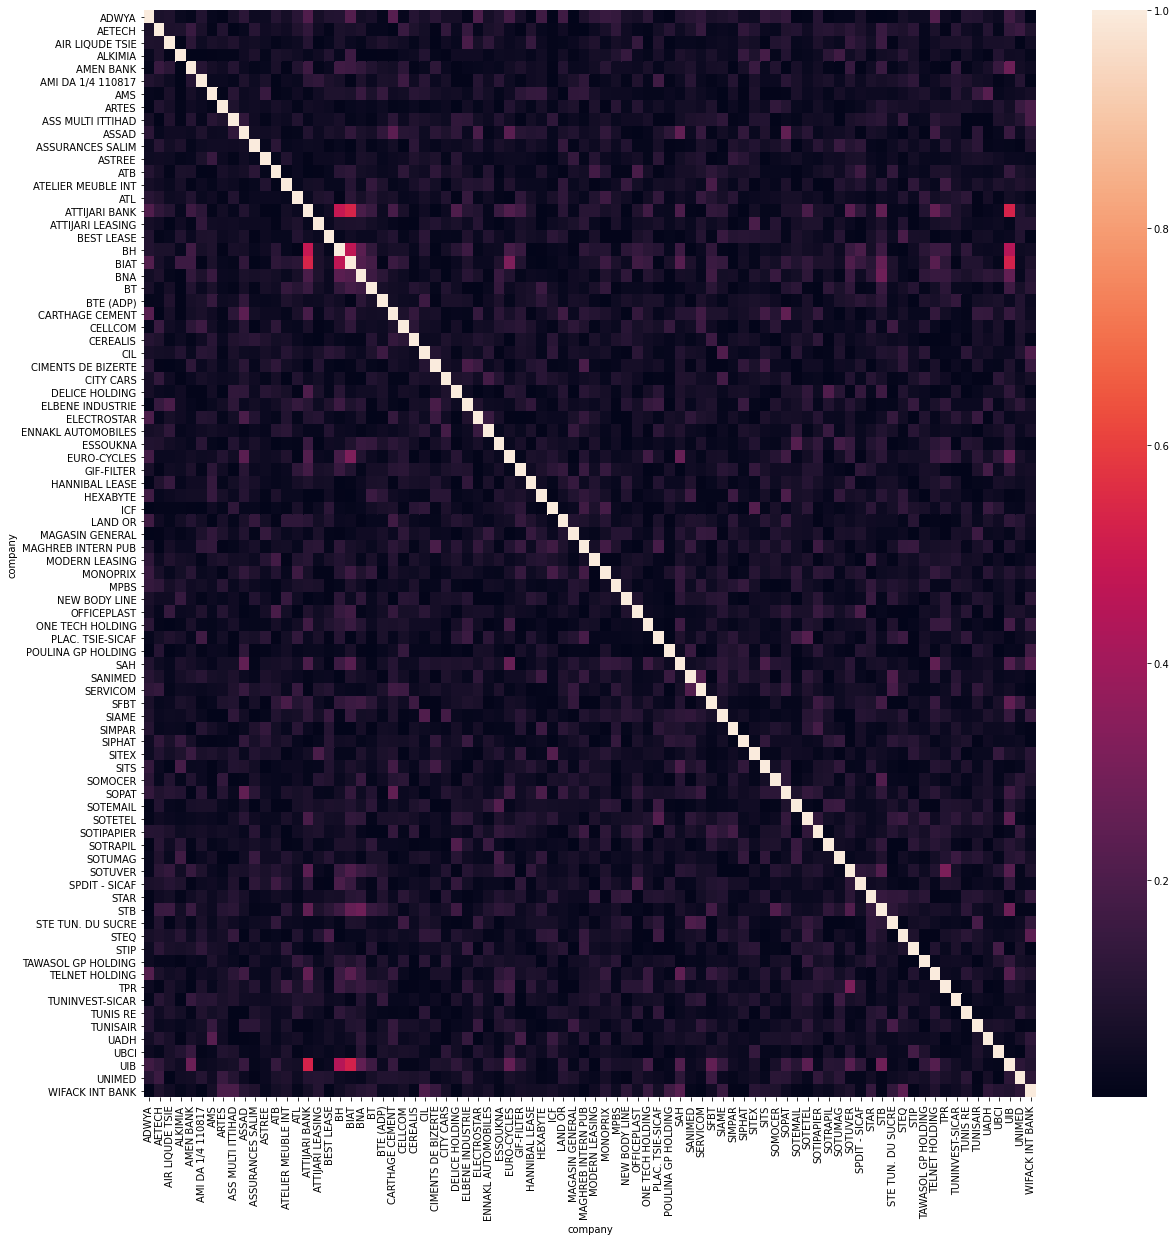

In [197]:
plt.figure(figsize=(20,20))
sns.heatmap(ret_data.corr().abs())
plt.show()

Plot with only the highest correlated stocks

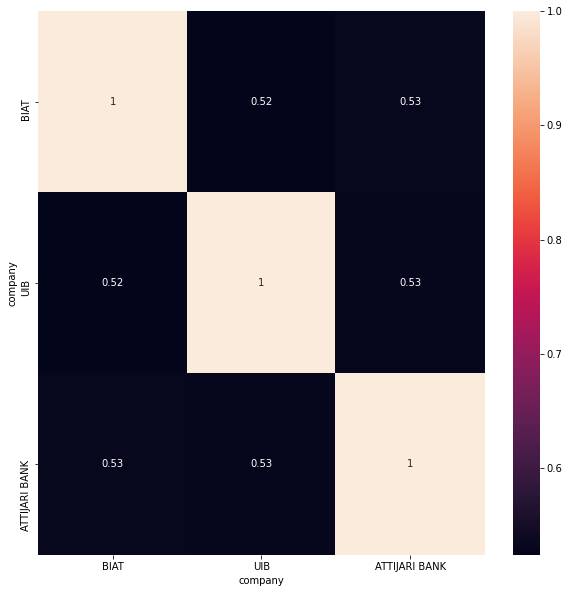

In [198]:
# Stocks with a correlation factor > 0.5
corr=np.matrix(ret_data.corr().abs())
high_corr=set()
n=len(corr)
for i in range(n):
    for j in range(n):
        if i==j:
            continue
        if corr[i,j]>0.5:
            high_corr.add(ret_data.columns[i])
            high_corr.add(ret_data.columns[j])

plt.figure(figsize=(10,10))
sns.heatmap(ret_data[high_corr].corr(),annot=True)
plt.show()


Let's draw the scatter plot for these companies

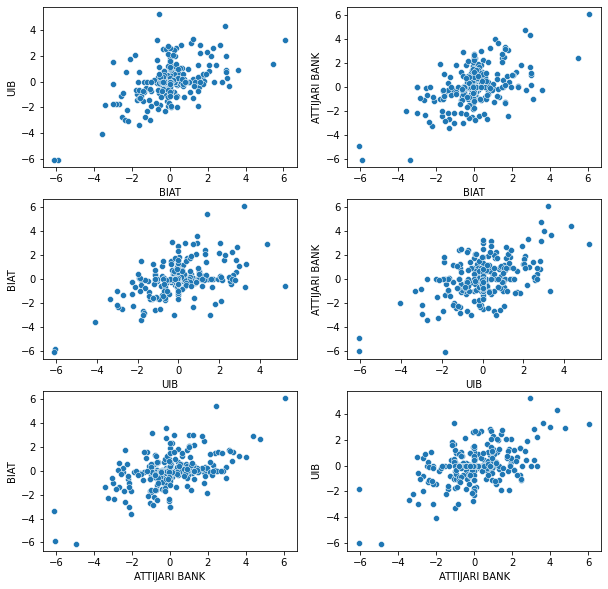

In [199]:
high_corr_data=ret_data[high_corr]
i=1
plt.figure(figsize=(10,10))
for col1 in high_corr_data:
    for col2 in high_corr_data:
        if col1==col2:
            continue
        plt.subplot(3,2,i)
        i+=1
        sns.scatterplot(y=high_corr_data[col2],x=high_corr_data[col1])

The correlation between stocks is not linear.

## part 2 : principal component analysis

Goal : perform the principal component analysis to understand what is driving the variance of the returns for the 84 stocks in the provided dataset. Please try to perform an analysis along the lines of the analysis we saw in class. It is important that you try to intrepret the results of the PCA. You may want to try running the analysis for various combinations of industries and analyze the results you get. You can find the industries for all the stocks in Tunisia Stock Exchange in https://www.ilboursa.com/marches/secteurs.aspx 

Please add as many cells as necessary below to answer this question.

### PCA for the whole dataset

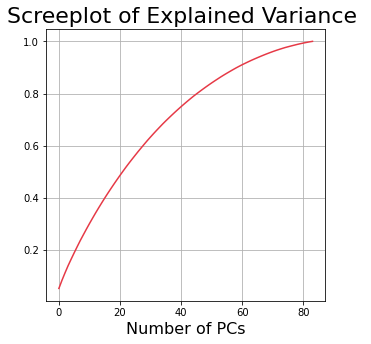

In [200]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data_scaled = StandardScaler().fit_transform(ret_data)
pca=PCA()
pca_data=pca.fit_transform(data_scaled)

variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(5,5))
plt.grid()
plt.plot(variance_exp_cumsum, color='#e63946')
plt.title('Screeplot of Explained Variance ', fontsize=22)
plt.xlabel('Number of PCs', fontsize=16)
plt.show()

In [201]:
optimal_PC= np.where(variance_exp_cumsum == variance_exp_cumsum[variance_exp_cumsum>0.9][0])[0][0]
print('The optimal number of compenents is therefore: \t',optimal_PC)

The optimal number of compenents is therefore: 	 59


### PCA for each industry

In [202]:
AGRO_AlIMENTAIRE = ['LAND OR', 'STE TUN. DU SUCRE', 'SFBT', 'DELICE HOLDING', 'CEREALIS', 'POULINA GP HOLDING', 'SOPAT', 'ELBENE INDUSTRIE']
ATUO = ['ASSAD', 'STEQ', 'GIF-FILTER', 'STIP']
BANQUES =['BT', 'ATTIJARI BANK', 'BH', 'BIAT', 'STB', 'AMEN BANK', 'ATB', 'WIFACK INT BANK', 'UBCI', 'UIB', 'BNA', 'BTE (ADP)']
BATIMENT = ['SITS', 'SIMPAR', 'SANIMED', 'ESSOUKNA', 'SOTEMAIL', 'SOMOCER']
TECHNOLOGIE = ['SERVICOM', 'ONE TECH HOLDING', 'TELNET HOLDING', 'SOTETEL', 'EURO-CYCLES', 'AETECH', 'HEXABYTE']
SERVICES_FINANCIERS = ['MAGHREB INTERN PUB', 'HANNIBAL LEASE', 'ASS MULTI ITTIHAD', 'BEST LEASE', 'TAWASOL GP HOLDING', 'CIL', 'ATTIJARI LEASING', 'TUNINVEST-SICAR', 'MODERN LEASING', 'ATL', 'SPDIT - SICAF', 'PLAC. TSIE-SICAF', 'TUNISAIR']
ASSURANCES = ['STAR', 'TUNIS RE', 'ASTREE']
SERVICE_INDUS = ['MPBS', 'SOTUVER', 'NEW BODY LINE', 'ELECTROSTAR', 'SOTIPAPIER', 'SOTRAPIL', 'SIAME', 'ATELIER MEUBLE INT', 'AMS', 'OFFICEPLAST']
PHARMACEUTIC =['SIPHAT', 'ADWYA', 'ICF', 'UNIMED', 'ALKIMIA', 'AIR LIQUDE TSIE']
MAT_PREMIERES = ['TPR', 'CIMENTS DE BIZERTE', 'CARTHAGE CEMENT']
DISTRIBUTION =['UADH', 'SAH', 'CELLCOM', 'SOTUMAG', 'CITY CARS', 'MAGASIN GENERAL', 'MONOPRIX', 'ARTES', 'ENNAKL AUTOMOBILES', 'SITEX']

secteurs={
    "BANQUES":BANQUES,
    "AGRO_AlIMENTAIRE":AGRO_AlIMENTAIRE,
    "ATUO":ATUO,
    "BATIMENT":BATIMENT,
    "TECHNOLOGIE":TECHNOLOGIE,
    "SERVICES_FINANCIERS":SERVICES_FINANCIERS,
    "ASSURANCES":ASSURANCES,
    "SERVICE_INDUS":SERVICE_INDUS,
    "PHARMACEUTIQUE":PHARMACEUTIC,
    "MAT_PREMIERES":MAT_PREMIERES,
    "DISTRIBUTION":DISTRIBUTION
}

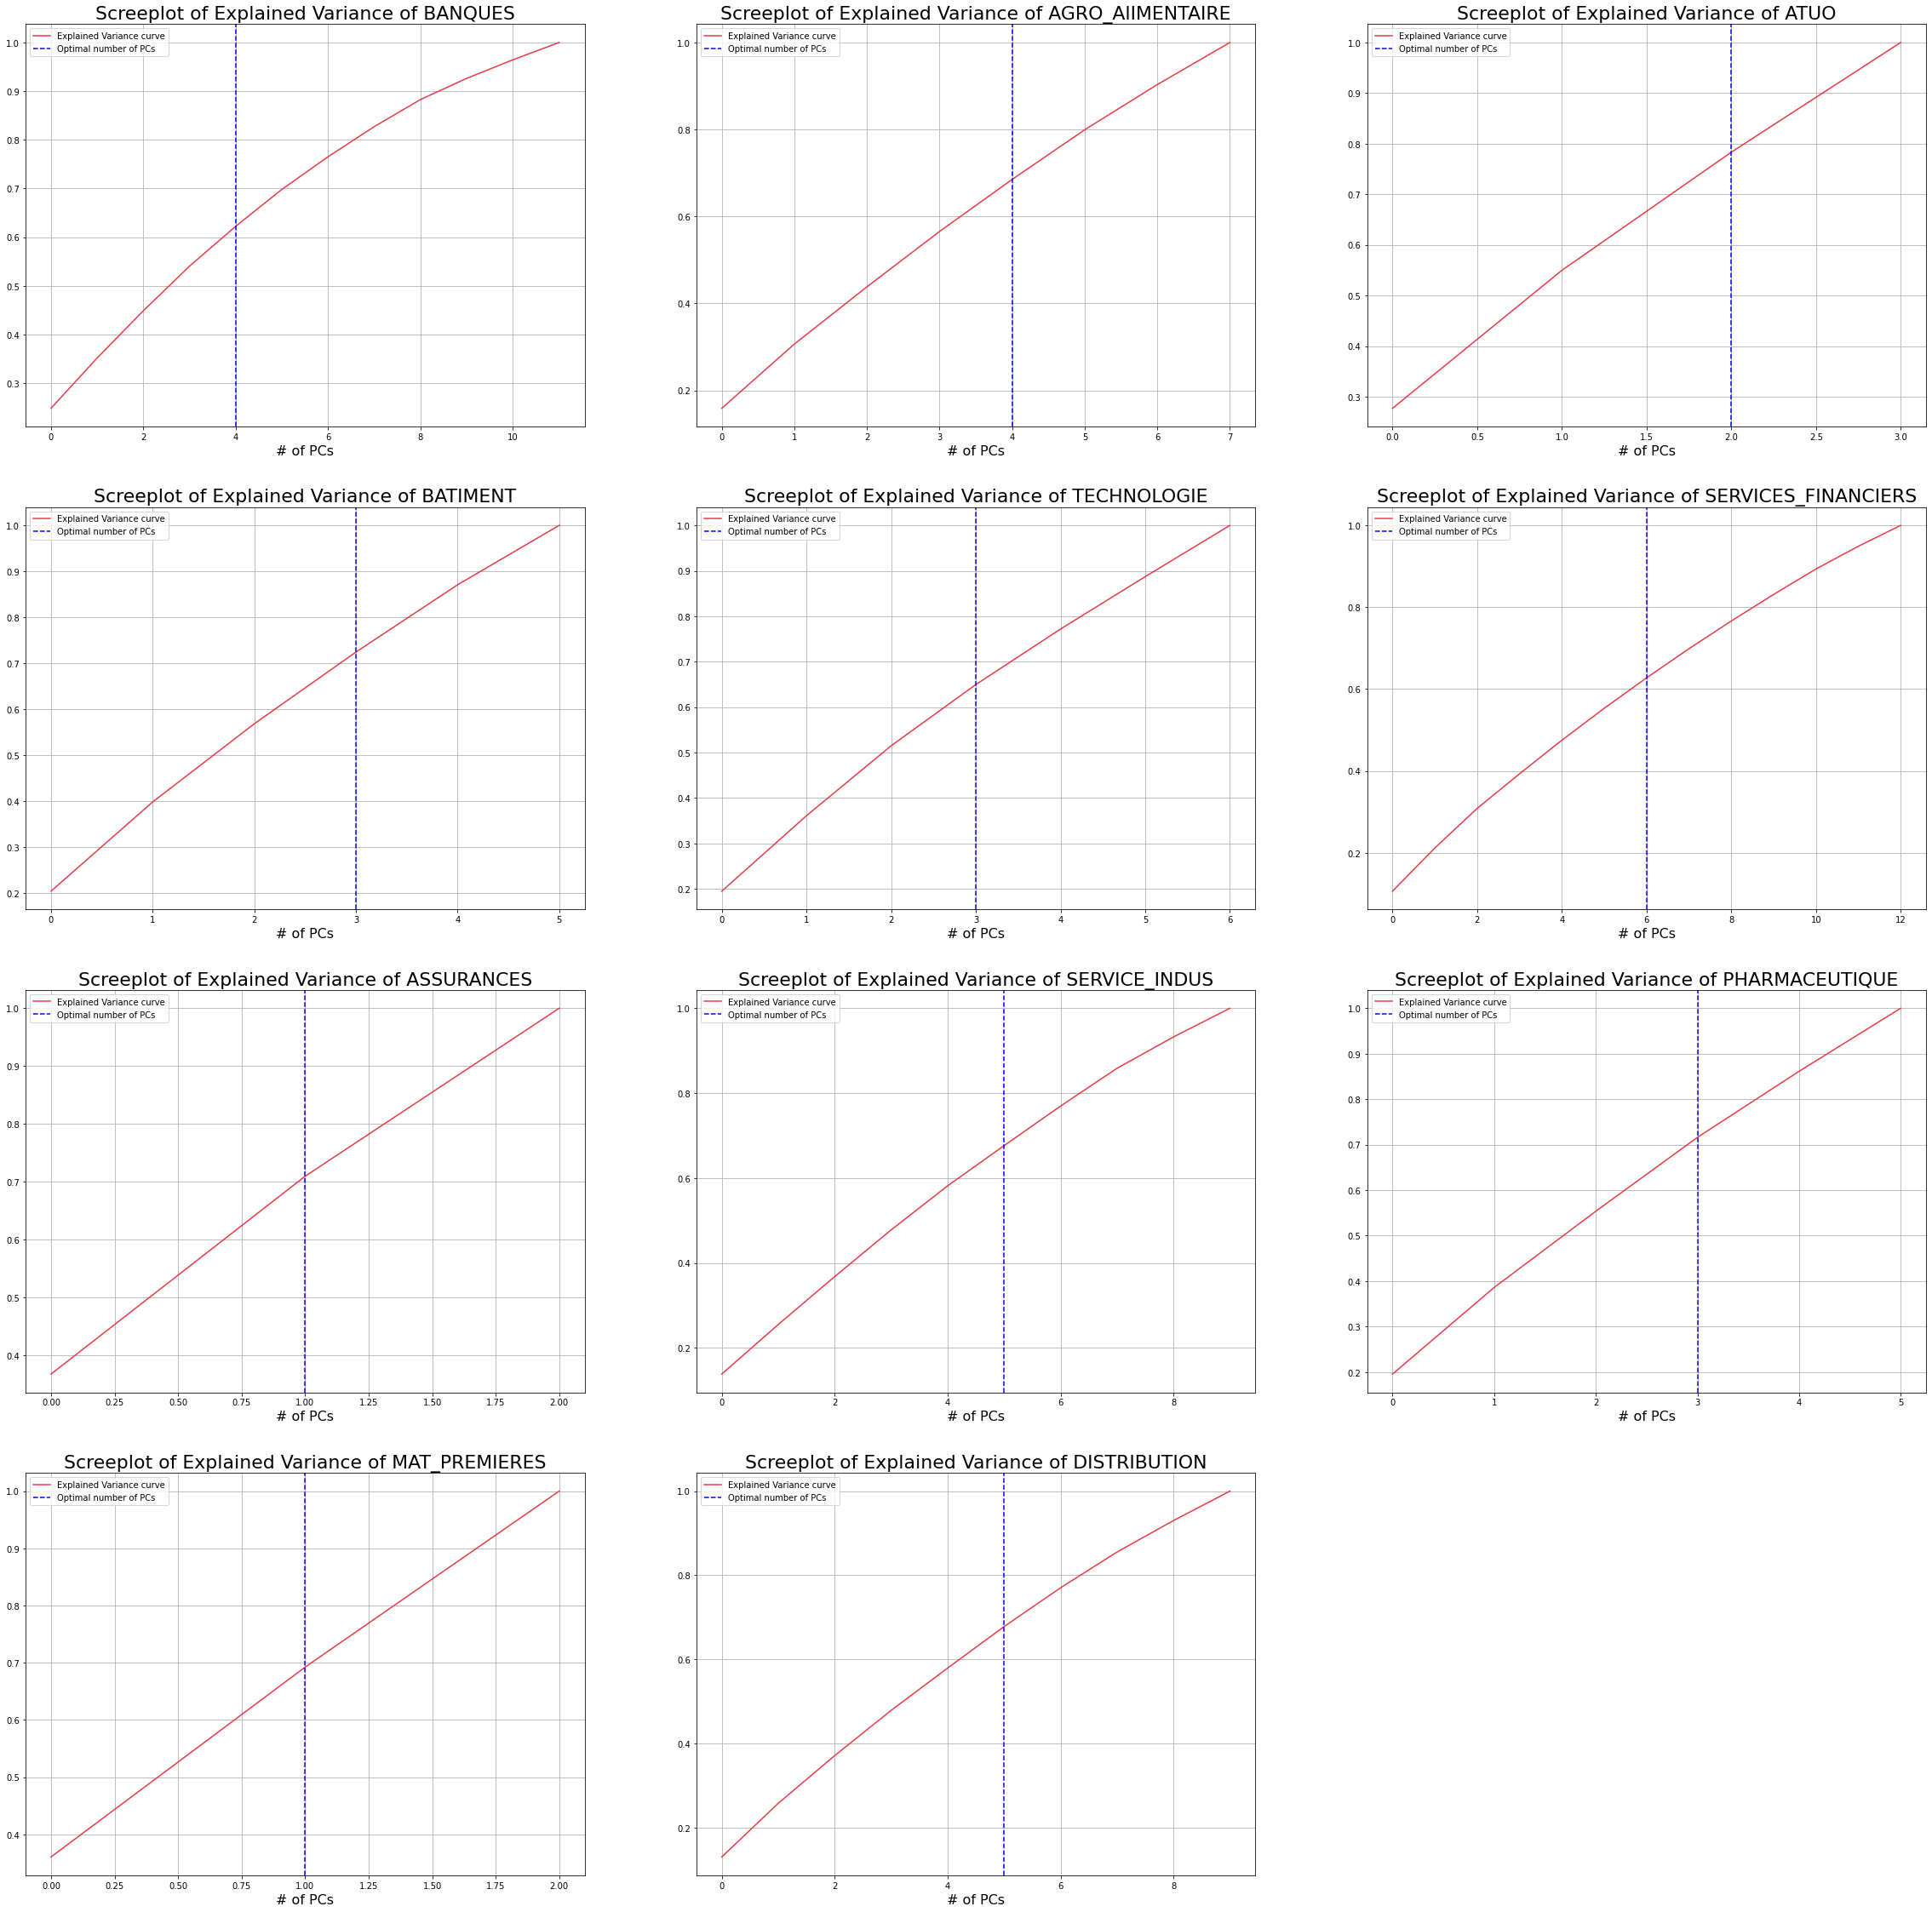

In [203]:
j=0
threshold=0.6
plt.figure(figsize=(40,40))
optimal_PCs=[]
for sector in secteurs.keys():
  j+=1
  pca=PCA()
  data=StandardScaler().fit_transform(ret_data[secteurs[sector]])
  pca.fit(data)
  variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
  optimal_PCs.append( np.where(variance_exp_cumsum == variance_exp_cumsum[variance_exp_cumsum>threshold][0])[0][0])
  plt.subplot(4,3,j)
  plt.grid()
  plt.plot(variance_exp_cumsum, color='#e63946',label='Explained Variance curve')
  plt.title('Screeplot of Explained Variance of '+sector, fontsize=22)
  plt.axvline(x = optimal_PCs[j-1], color = 'b', label = 'Optimal number of PCs',linestyle='--')
  plt.xlabel('# of PCs', fontsize=16)
  plt.legend()


This plot will allow us to choose the number of PCs to use for each industry in order to retain 70% of the variance.

### PCA for a combinaison of industries

We will now perform the principal component analysis for the combinaison of raw materials companies and pharmaceutical companies.

In [204]:
cols=MAT_PREMIERES+PHARMACEUTIC # you may want to try running the analysis for various combinations of industries
df1=ret_data[cols]

X = np.asarray(df1)

[n,m] = X.shape
print('The number of timestamps is {}.'.format(n))
print('The number of stocks is {}.'.format(m))

from sklearn.decomposition import PCA
num_pc = 4
pca = PCA(num_pc)
pca.fit(X)

percentage =  pca.explained_variance_ratio_
percentage_cum = np.cumsum(percentage)
print('{0:.2f}% of the variance is explained by the first'.format(percentage_cum[-1]*100),num_pc,'principal components.')

pca_components = pca.components_

The number of timestamps is 248.
The number of stocks is 9.
69.29% of the variance is explained by the first 4 principal components.


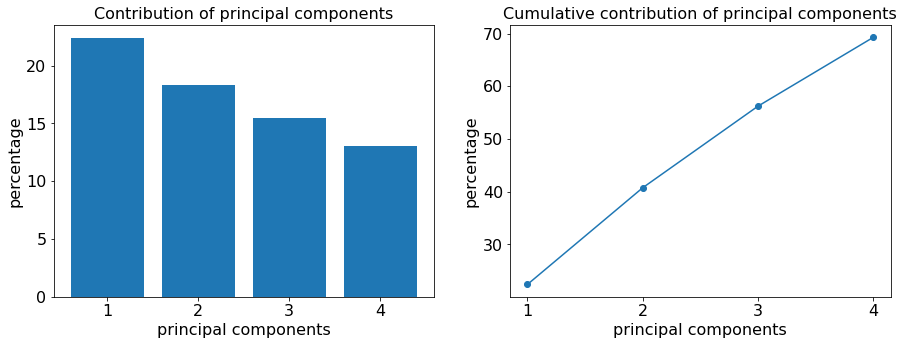

In [205]:
plt.figure(figsize=(15,5))

x = np.arange(1,len(percentage)+1,1)
plt.subplots_adjust(wspace = 0.2)

plt.subplot(1, 2, 1)
plt.bar(x, percentage*100, align = "center")
plt.title('Contribution of principal components',fontsize = 16)
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)

plt.subplot(1, 2, 2)
plt.plot(x, percentage_cum*100,'o-')
plt.xlabel('principal components',fontsize = 16)
plt.ylabel('percentage',fontsize = 16)
plt.title('Cumulative contribution of principal components',fontsize = 16)
plt.xticks(x,fontsize = 16) 
plt.yticks(fontsize = 16)

plt.show()

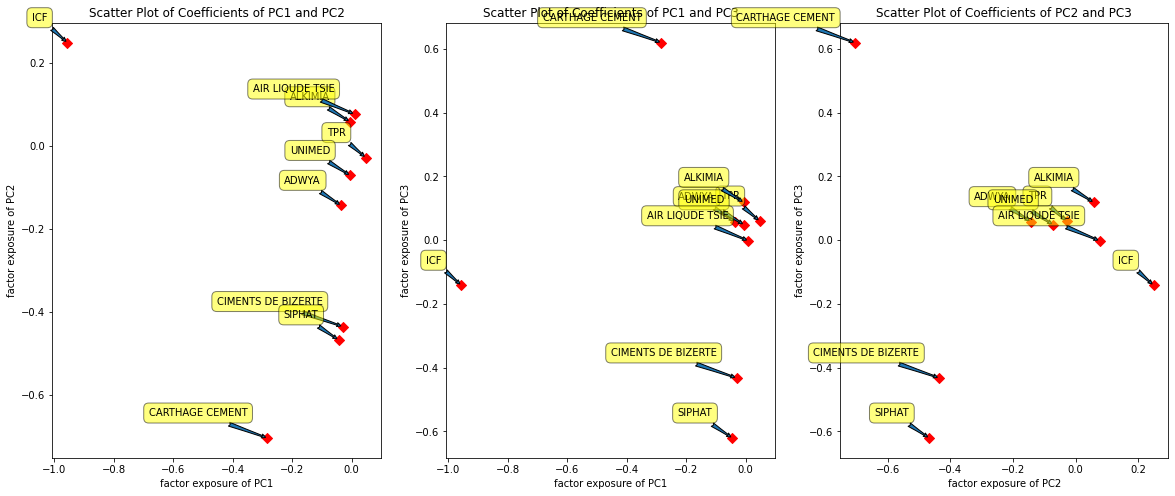

In [206]:
factor_exposures = pd.DataFrame(index=["factor "+str(i) for i in range(1,num_pc+1)], columns=df1.columns, data = pca.components_).T

labels = factor_exposures.index
data = factor_exposures.values

fig,ax=plt.subplots(nrows=1, ncols=3, figsize=(20,8))

ax[0].scatter(data[:, 0], data[:, 1], marker='D', s=50, c='r')
ax[0].set_title('Scatter Plot of Coefficients of PC1 and PC2')
ax[0].set_xlabel('factor exposure of PC1')
ax[0].set_ylabel('factor exposure of PC2')
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    ax[0].annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = 'fancy', connectionstyle='arc3,rad=0'))

ax[1].scatter(data[:, 0], data[:, 2], marker='D', s=50, c='r')
ax[1].set_title('Scatter Plot of Coefficients of PC1 and PC3')
ax[1].set_xlabel('factor exposure of PC1')
ax[1].set_ylabel('factor exposure of PC3')
for label, x, y in zip(labels, data[:, 0], data[:, 2]):
    ax[1].annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = 'fancy', connectionstyle='arc3,rad=0'))

ax[2].scatter(data[:, 1], data[:, 2], marker='D', s=50, c='r')
ax[2].set_title('Scatter Plot of Coefficients of PC2 and PC3')
ax[2].set_xlabel('factor exposure of PC2')
ax[2].set_ylabel('factor exposure of PC3')
for label, x, y in zip(labels, data[:, 1], data[:, 2]):
    ax[2].annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = 'fancy', connectionstyle='arc3,rad=0'))    

Raw materials and pharmaceutics companies can clearly be distinguished using PC coefficients as companies of each of these two sectors are grouped together when plotted in the PC space.

## part 3 : factor analysis

Goal : perform the factor analysis on the returns for the 84 stocks in the provided dataset. It is important that you try to interpret the results of the FA. You may want to try running the analysis for various combinations of industries and analyze the results you get. You can find the industries for all the stocks in Tunisia Stock Exchange in https://www.ilboursa.com/marches/secteurs.aspx

You will need to install factor-analyzer (https://pypi.org/project/factor-analyzer/) to perform the factor analysis exercise. You can find a variety of examples in the documentation of the package : https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

You may want to take a look at the following link regarding how to choose the factor in the FA: https://www.theanalysisfactor.com/factor-analysis-how-many-factors/

Please add as many cells as necessary below to answer this question.

### Fctor analysis for the whole dataset

#### Check if we can perform factor analysis on our dataset?
___Bartlett's Test :___ if the p_value is less than 0.05 then we can employ the factor analysis.

In [207]:
!pip install factor_analyzer


In [208]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
p_value=calculate_bartlett_sphericity(data_scaled)[1]

print('The p-value is {}'.format(p_value))

The p-value is 4.8951543670129843e-23


p-value<0.05

we can perform factor analysis.

In [209]:
# Create factor analysis object and perform factor analysis
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation="varimax",n_factors=ret_data.shape[1])
fa.fit(data_scaled)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

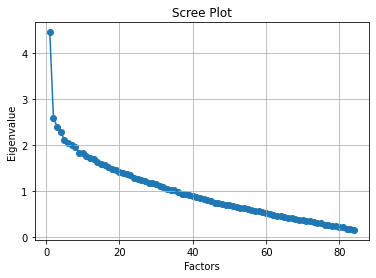

In [210]:
# Create scree plot using matplotlib
plt.scatter(range(1,data_scaled.shape[1]+1),ev)
plt.plot(range(1,data_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [211]:
# the optimal number of FA is the number for which the eigenvalues are greater than one.
optimal_FA=len(ev[ev>=1])
optimal_FA

35

### Factor analysis for a combinaison of industries

We will now perform the factor analysis for the combinaison of raw materials companies and pharmaceutical companies.

In [212]:
cols=MAT_PREMIERES+PHARMACEUTIC# you may want to try running the analysis for various combinations of industries
ind_comb_data=ret_data[cols]

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
p_value=calculate_bartlett_sphericity(ind_comb_data)[1]

print('The p-value is {}'.format(p_value))

The p-value is 0.007866353851893094


p-value<0.05

we can perform factor analysis.

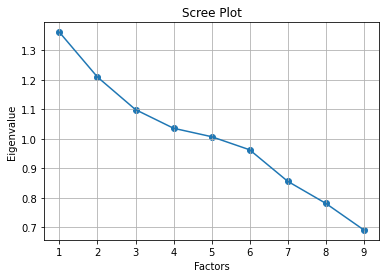

In [213]:
# Create factor analysis object and perform factor analysis
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation="varimax",n_factors=ind_comb_data.shape[1])
fa.fit(ind_comb_data)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
# Create scree plot using matplotlib
plt.scatter(range(1,ind_comb_data.shape[1]+1),ev)
plt.plot(range(1,ind_comb_data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


So we will use 5 factors.

In [214]:
n_factors=5

fa = FactorAnalyzer(n_factors)
fa.fit(ind_comb_data)

cols=['Factor '+str(i) for i in range(1,n_factors+1)]
indx=['Variance', 'Propotional varience', 'Cumulative variance']

data_loadings=pd.DataFrame(fa.loadings_, index=ind_comb_data.columns, columns=cols)

data_variance=pd.DataFrame(fa.get_factor_variance(), index=indx, columns=cols)

data_variance.head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Variance,1.035130,1.031823,1.022347,0.627051,0.334891
Propotional varience,0.115014,0.114647,0.113594,0.069672,0.037210
Cumulative variance,0.115014,0.229661,0.343256,0.412928,0.450138


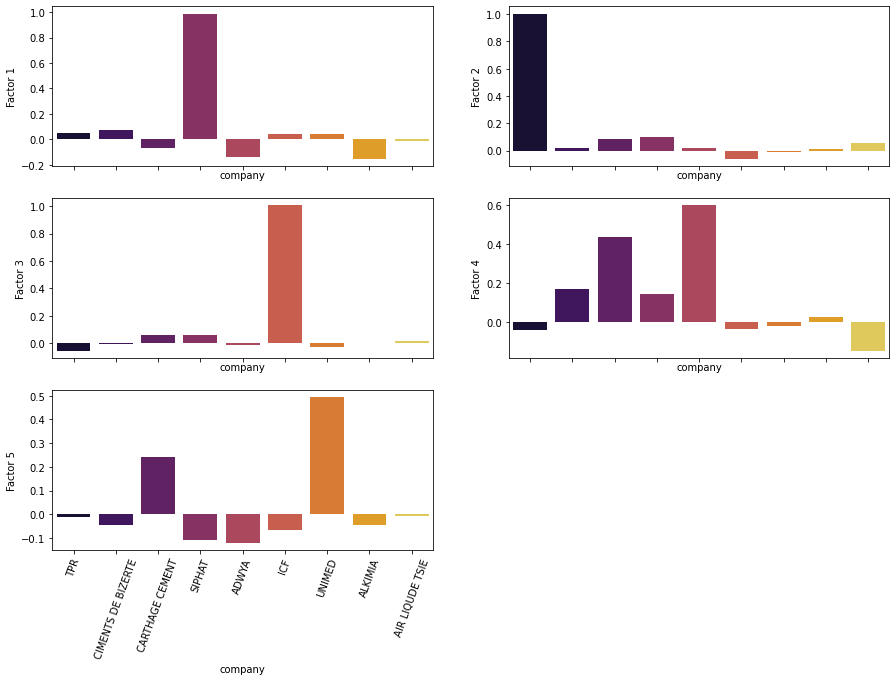

In [215]:
fig, ax=plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(15,10))
fig.delaxes(ax[2,1])
places=[(0,0),(0,1),(1,0),(1,1),(2,0)]

for i in range(1,n_factors+1):
    a,b=places[i-1][0], places[i-1][1]
    col_name='Factor '+str(i)
    sns.barplot(x=data_loadings.index, y=data_loadings[col_name], ax=ax[a,b], palette='inferno')
    ax[a,b].set_xticklabels(labels=data_loadings.index, rotation=70)
    
plt.show()    

## part 4 : predictive modelling

Goal : try to build a model that predicts the next day market returns (next_day_mkt_ret column in ret_data) using the techniques that we covered in class. You may want to :
1. perform an exploratory data analysis 
2. use linear models with polynomial / interactions transformations along with cross validation

Please add as many cells as necessary below to answer this question.

In [216]:
# now let's define the next day market returns
ret_data['next_day_mkt_ret'] = ret_data.mean(1).shift(-1)

In [217]:
ret_data['next_day_mkt_ret']

date
2018-01-03    0.279106
2018-01-04    0.035407
2018-01-05    0.468555
2018-01-08   -0.515412
2018-01-09   -0.448612
                ...   
2018-12-25    0.088131
2018-12-26    0.624504
2018-12-27    0.695785
2018-12-28    0.372748
2018-12-31         NaN
Name: next_day_mkt_ret, Length: 248, dtype: float64

In [218]:
ret_data.head()

company,ADWYA,AETECH,AIR LIQUDE TSIE,ALKIMIA,AMEN BANK,AMI DA 1/4 110817,AMS,ARTES,ASS MULTI ITTIHAD,ASSAD,ASSURANCES SALIM,ASTREE,ATB,ATELIER MEUBLE INT,ATL,ATTIJARI BANK,ATTIJARI LEASING,BEST LEASE,BH,BIAT,BNA,BT,BTE (ADP),CARTHAGE CEMENT,CELLCOM,CEREALIS,CIL,CIMENTS DE BIZERTE,CITY CARS,DELICE HOLDING,ELBENE INDUSTRIE,ELECTROSTAR,ENNAKL AUTOMOBILES,ESSOUKNA,EURO-CYCLES,GIF-FILTER,HANNIBAL LEASE,HEXABYTE,ICF,LAND OR,...,NEW BODY LINE,OFFICEPLAST,ONE TECH HOLDING,PLAC. TSIE-SICAF,POULINA GP HOLDING,SAH,SANIMED,SERVICOM,SFBT,SIAME,SIMPAR,SIPHAT,SITEX,SITS,SOMOCER,SOPAT,SOTEMAIL,SOTETEL,SOTIPAPIER,SOTRAPIL,SOTUMAG,SOTUVER,SPDIT - SICAF,STAR,STB,STE TUN. DU SUCRE,STEQ,STIP,TAWASOL GP HOLDING,TELNET HOLDING,TPR,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK,next_day_mkt_ret
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.742115,3.921569,0.000000,0.000000,-0.041667,-13.824885,-2.542373,2.459016,-3.030303,-0.111111,0.000000,0.0,-0.717703,0.000000,0.000000,-1.229508,-0.950783,-2.631579,-0.270563,1.608806,0.775194,0.128041,-2.382336,-0.858369,0.529101,-1.975309,2.731591,-0.400000,2.976744,0.000000,0.0,0.754717,1.612903,-1.084011,3.773585,-2.702703,0.000000,0.189394,0.284394,-3.333333,...,-1.010101,-4.687500,4.393939,0.0,5.316224,0.902643,-0.233645,-1.315789,2.474227,-2.953586,2.780374,-2.830189,0.00,0.000000,3.448276,0.000000,0.0,0.355872,-0.568182,0.093458,1.036269,-2.834008,-1.219512,2.040816,0.813008,0.000000,0.000000,0.0,-2.631579,1.365188,-2.298851,0.000000,-1.785714,-2.325581,0.408163,0.0,0.408905,1.910828,-0.269179,0.279106
2018-01-04,3.738318,3.773585,-1.123596,-2.998921,-0.375156,0.000000,0.000000,0.160000,-4.500000,1.112347,0.000000,0.0,0.481928,-0.401606,0.323625,0.885201,0.282326,2.162162,-2.333152,-1.250000,-0.085470,0.000000,0.059524,-0.432900,-0.526316,2.770781,2.774566,0.000000,-0.632340,2.909091,0.0,-1.498127,-0.793651,2.465753,3.600000,2.777778,0.372208,-2.835539,2.800425,2.068966,...,-2.857143,-5.901639,-1.306241,0.0,-1.479547,0.894569,-0.468384,6.000000,-0.503018,-0.434783,-1.113890,-0.776699,0.00,4.680851,2.500000,2.702703,0.0,2.127660,-0.285714,1.774043,0.000000,-2.916667,0.000000,-0.020000,-0.537634,0.000000,0.000000,0.0,-2.702703,2.693603,-3.235294,0.000000,3.030303,2.380952,5.691057,0.0,-0.452489,-0.250000,-2.968961,0.035407
2018-01-05,0.540541,1.818182,0.227273,-4.492883,0.334728,0.000000,0.000000,0.000000,-1.832461,1.210121,-2.985075,0.0,-1.199041,-2.016129,0.645161,1.069372,0.225225,0.000000,-0.166667,1.181435,-0.769889,0.000000,2.498513,2.173913,-2.645503,-0.490196,0.000000,0.000000,4.454545,-0.471143,0.0,-0.380228,0.800000,0.802139,-1.755002,-1.351351,-1.112485,1.945525,0.000000,2.972973,...,0.840336,-4.181185,-1.397059,0.0,0.000000,2.596580,0.000000,5.660377,0.000000,-3.493450,-1.149425,2.935421,0.00,5.691057,4.878049,0.000000,0.0,0.000000,-2.578797,0.825688,-2.564103,-1.287554,0.000000,-2.980596,-2.162162,0.000000,0.000000,0.0,0.000000,1.311475,0.000000,2.923077,-1.294118,-2.325581,3.461538,0.0,0.000000,0.250627,-0.139082,0.468555
2018-01-08,-1.433692,3.571429,0.000000,-2.328831,0.000000,0.534759,0.000000,-2.555911,5.866667,1.630435,0.000000,0.0,1.213592,-1.234568,0.000000,1.275095,-0.112360,0.000000,-0.946021,2.193495,-1.206897,0.000000,5.861869,0.851064,1.086957,0.000000,-1.631046,0.000000,-1.218451,0.118343,0.0,-2.671756,-0.793651,1.326260,0.643087,-1.369863,0.000000,0.000000,0.000000,1.706037,...,-0.208333,5.818182,3.877703,0.0,-1.943463,5.802469,-2.823529,0.000000,0.606673,1.357466,2.325581,-2.851711,0.00,3.846154,2.325581,-2.631579,0.0,0.000000,-0.294118,0.000000,2.105263,2.826087,1.234568,-0.010309,0.276243,0.000000,4.461942,0.0,0.000000,0.970874,2.431611,0.000000,-2.145411,-2.380952,-1.486989,0.0,2.000000,2.500000,2.924791,-0.515412
2018-01-09,0.000000,0.000000,0.000000,0.000000,-0.041701,5.851064,0.000000,0.819672,-2.392947,1.497326,0.000000,0.0,-0.479616,-0.416667,-0.641026,0.107152,-0.168729,0.000000,-0.674157,-0.514

Let's plot the new column to see what type of forecasting we should use

### Data cleaning

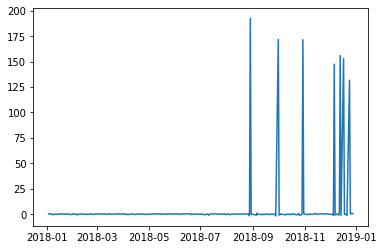

In [219]:
plt.plot(ret_data["next_day_mkt_ret"])

Upon ploting the next day data, we suspect the existence of outilers so let's draw a boxplot to make sure.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


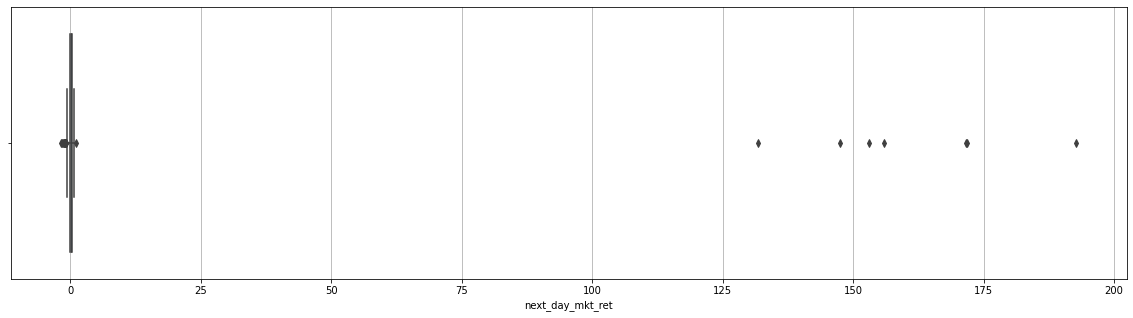

In [220]:
plt.figure(figsize=(20,5))
plt.grid()
sns.boxplot(ret_data['next_day_mkt_ret'])
plt.show()

We must remove outliers that verify:

$$\text{next_day_mkt_ret} \leq Q1-1.5 \times IQR \\ or \\ \text{next_day_mkt_ret} \geq Q3 + 1.5 \times IQR $$

In [221]:
Q1 = np.nanpercentile(ret_data['next_day_mkt_ret'], 25, interpolation = 'midpoint') 
Q3 = np.nanpercentile(ret_data['next_day_mkt_ret'], 75, interpolation = 'midpoint')
IQR=Q3-Q1 
ret_data=ret_data.drop(ret_data[ret_data['next_day_mkt_ret']>Q3+1.5*IQR].index)
ret_data=ret_data.drop(ret_data[ret_data['next_day_mkt_ret']<Q1-1.5*IQR].index)

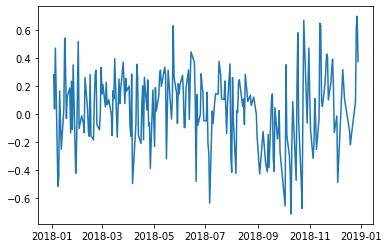

In [222]:
plt.plot(ret_data["next_day_mkt_ret"])

In [223]:
col_name = ret_data.columns.to_series()[np.isinf(ret_data).any()]
ret_data[col_name]=ret_data[col_name].replace([np.inf, -np.inf],np.nan)
ret_data[col_name]=ret_data[col_name].fillna(ret_data[col_name].mean())

In [224]:
X=ret_data.drop("next_day_mkt_ret",axis=1)
Y=ret_data["next_day_mkt_ret"]

Y.replace([np.inf, -np.inf], np.nan, inplace=True)
Y.fillna(Y.mean(), inplace=True)

In [225]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

X_scaled=sc.fit_transform(X)
X_scaled.shape

(227, 84)

### Polynomial Regression

First, we will try to predict the next day returns using polynomial regression like we did in class.

We will consider the companies daily returns as X and the next day returns as Y.

Note that using this approach, the model's training takes a very long time so we will only consider a few companies in order to reduce complexity and try this first idea.

We will later use an other more appropriate model.

In [226]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2,**kwargs):
    return make_pipeline(PolynomialFeatures(degree),LinearRegression(**kwargs))

In order to perform cross validation, we will use TimeSeriesSplit which splits the data into k folds in a way that the data used for training is always dated before the test data which is important when working with time series.

In [227]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=3)


In [228]:
X=X[['AMS','ATB','ADWYA','AETECH']]
degree=10
from sklearn.metrics import mean_squared_error

for train_index, test_index in tscv.split(np.array(X)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  # model
  y_reg = PolynomialRegression(degree).fit(X_train,y_train)
  y_model=y_reg.predict(X_test)
  print('RMSE for Polynomial Regression:',np.sqrt(mean_squared_error(y_test,y_model)))

RMSE for Polynomial Regression: 13284587.390431143
RMSE for Polynomial Regression: 1581170.274110957
RMSE for Polynomial Regression: 43958134.837185115


### Exponential Smoothing

*About the model used:*

Exponential smoothing of time series data assigns exponentially decreasing weights for newest to oldest observations. In other words, the older the data, the less priority (“weight”) the data is given; newer data is seen as more relevant and is assigned more weight. Smoothing parameters (smoothing constants)— usually denoted by α— determine the weights for observations.

Exponential smoothing is usually used to make short term forecasts.

Triple exponential smoothing (also called the Multiplicative Holt-Winters) used here is usually more reliable for parabolic trends or data that shows trends and seasonality..



We will now try to predict the next day's return using Exponential Smoothing.

But first we need to adjust the data so that we have stock values for every day. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


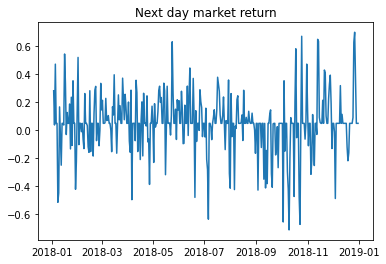

In [229]:
index= pd.date_range(start='2018-01-03', end='2018-12-31', freq='D')
new_data=pd.Series(index=index)
for date in Y.index:
  new_data[ (str(date)[:10]) ] = Y[date] 
new_data=new_data.fillna(new_data.mean())

plt.plot(new_data)
plt.title("Next day market return")
plt.show()

Now we will train the model and visualize how it smoothens the time series(we will plot the fitted values for the training data).

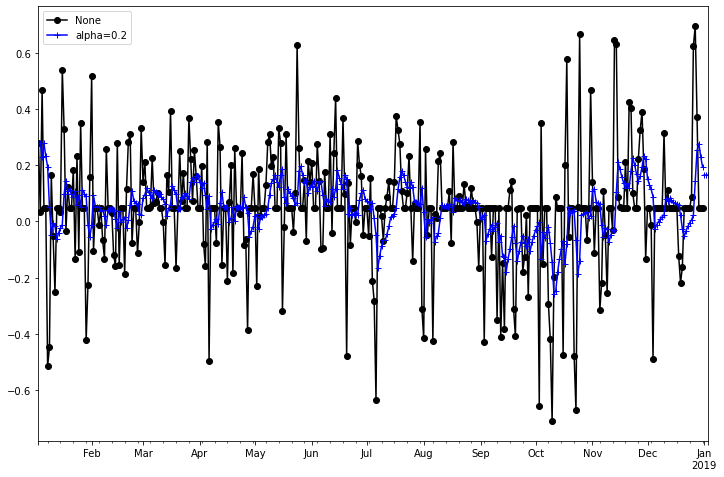

In [230]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
data=new_data
# model
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(3).rename('alpha=0.2')

# After creating model we will visualize the plot
ax = data.plot(marker='o', color='black', figsize=(12,8), legend=True)

# Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

plt.show()

Now we will use time cross validation like before to train the model on the first part of the data and try to predict the second part.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


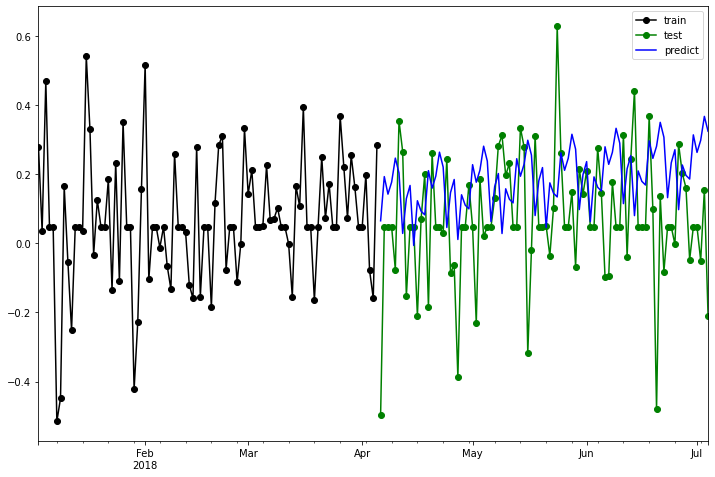

RMS Error is  0.24066136191137494


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


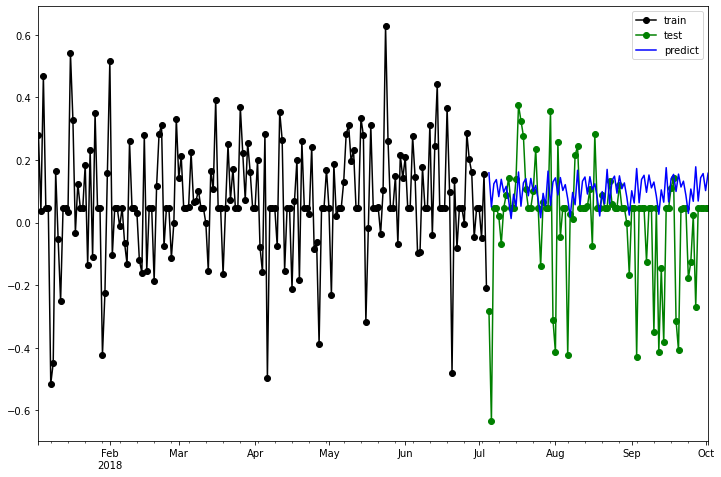

RMS Error is  0.2127463810980198


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


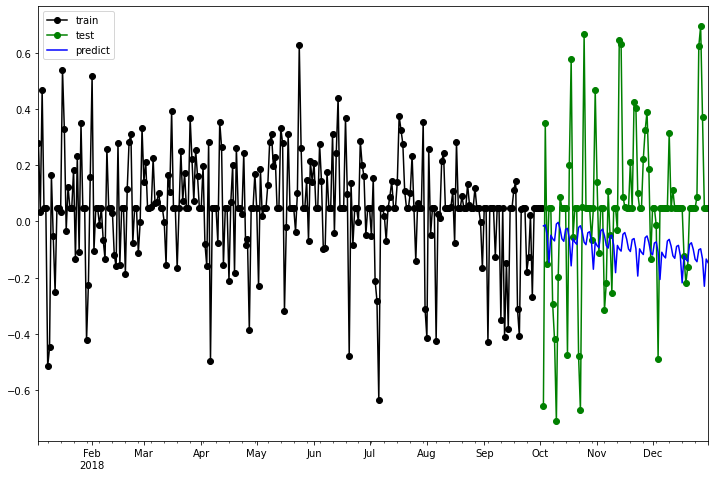

RMS Error is  0.31498675168610285


In [231]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(np.array(new_data)):
  # train test splitting for 3 fold cross validation
  y_train, y_test = new_data.iloc[train_index], new_data.iloc[test_index]
  # plotting train and test data
  ax = y_train.plot(marker='o', color='black', figsize=(12,8), legend=True, label='train')
  ax = y_test.plot(marker='o', color='green',label='test')

  # model training
  model = ExponentialSmoothing(y_train,trend='add',seasonal='add',seasonal_periods=12).fit()

  # prediction 
  start=str(y_test.index[0])[0:10]
  end=str(y_test.index[-1])[0:10]
  y_predict=model.predict(start=start,end=end)
  # plotting predicted stocks
  y_predict.plot(color='blue',label='predict')
  plt.legend()
  plt.show()
  # error
  rms_error = np.sqrt(mean_squared_error(y_predict,y_test))
  print("RMS Error is ",rms_error)

The RMS error using this method is much smaller than the RMS error using polynomial regression but the predictions are not always close to the real values using this model.